# Artificial Intelligent course - Fall 2023
## CA#2: Curvefitting using Gentetic Algorithms
## Mohammad Amin Yousefi
### SID: 810100236

#### Problem Description
in this project we are given some points and some boundaries for our coefficients and we have to randomly generate a population and improve it until achieving an equation with desired degree.

#### Goal
I have tried to implement an efficient genetic algorithm using basic python OOP in order to find the best coefficients for desired polynomial.

I have collected all needed constant values in a dataclass to keep my code clean and easy to modify.

In [1]:
from dataclasses import dataclass
from typing import Optional
import random

@dataclass
class DataTable:
    curve_degree: int
    generation_size : int
    coeff_boundaries: tuple
    points: list[tuple]
    crossover_probability: int 
    mutation_probability: int
    carry_percentage: float
    generation_number: int

we define our constant values by instantiating data_table. these numbers are found by testing various test numbers.

In [33]:
# [(1,2),(3,-990),(2,-87),(-3,2418),(0,3)]
# [(1,7),(2,527),(3,9723),(0,9),(-1,11),(-2,-677),(-3,-12153)]
# [(0,1),(1,0),(2,-5),(-1,-8)]
data_table = DataTable(
    curve_degree= 3,
    generation_size= 500,
    coeff_boundaries = (-10,10),
    points = [(0,1),(1,0),(2,-5),(-1,-8)],
    crossover_probability = 0.6,
    mutation_probability = 0.2,
    carry_percentage = 20/100,
    generation_number = 1000
)

### Error calculation
- MSE is our error function. in this case, we have used error calculation instead of fitness calculation, therefor we try to minimize error.
$$Mean Squared Error = \frac{1}{n}\sum_{i=1}^{n} (Y_i-\hat{Y_i})^2$$

In [3]:
def MSE(y,pred):
    res=0
    for i in range(len(y)):
        res += (pred[i]-y[i]) ** 2
    return res/len(y)

def calc_predicts(coeffs):
    return [sum([coeffs[i]*(points_x**i) for i in range(len(coeffs))]) for points_x in [point[0] for point in data_table.points]]

- This function helps us to visualize our curve and points using to examine whether our curve fites or not.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_outpu(coefficients):
    coefficients.reverse()
    points_x = [x[0] for x in data_table.points]
    points_y = [x[1] for x in data_table.points]
    
    if min(points_x) < 0:
        min_xlim = min(points_x) + min(points_x)/2
    else:
        min_xlim = min(points_x) - min(points_x)/2
    if max(points_x) < 0:
        max_xlim = max(points_x) - max(points_x)/2
    else:
        max_xlim = max(points_x) + max(points_x)/2
        
    x = np.linspace(min_xlim, max_xlim, 600)
    y = np.polyval(coefficients, x)
    plt.plot(x, y, label='Polynomial Curve', color='b')
    plt.scatter(points_x, points_y, color='r', label='Data Points')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

- This function is printing the final polynomial equation.

In [5]:
def print_output(best_Chromosome):
    res = f"{best_Chromosome.coefficients[0]} "
    for i in range(1,data_table.curve_degree + 1):
        if best_Chromosome.coefficients[i] != 0:
            if best_Chromosome.coefficients[i] > 0:
                res += f"+ {best_Chromosome.coefficients[i]}x^{i} "
            else:
                res += f"{best_Chromosome.coefficients[i]}x^{i} "

    print(f"Polynomial equation is: {res}")
    print(f"Coefficients are: {best_Chromosome.coefficients}")
    print(f"MSE in this case is: {best_Chromosome.error}")

### Chromosome Class

- each chromosome consists of a set of coefficients and is a polynomial curve. coefficients are ordered from C(0) to C(n-1). we choose the first generation by randomly generating numbers. after setting coefficients, we calculate chromosomes error(MSE).
- in mutation phaze, if random generated number becomes less than mutation_probability, we randomly select a coefficient and replace it with a random bounded number.

In [10]:
class Chromosome:
    def __init__(self, coefficients: Optional[list[int]] = None):
        self.error = 0
        self.coefficients = coefficients if coefficients \
                            else \
                                [random.randint(data_table.coeff_boundaries[0], data_table.coeff_boundaries[1]) for x in range(data_table.curve_degree + 1)]
        while self.coefficients[-1] == 0:
            self.coefficients[-1] = random.randint(data_table.coeff_boundaries[0], data_table.coeff_boundaries[1])
        self.calc_error()

        
    def calc_error(self):
        self.error = MSE([x[1] for x in data_table.points], calc_predicts(self.coefficients))

    def mutate(self):
        if random.random() < data_table.mutation_probability:
            index = random.randint(0, data_table.curve_degree)
            new_coeff = random.randint(data_table.coeff_boundaries[0], data_table.coeff_boundaries[1])
            while new_coeff == self.coefficients[index] or new_coeff == 0:
                new_coeff = random.randint(data_table.coeff_boundaries[0], data_table.coeff_boundaries[1])
            self.coefficients[index] = new_coeff

### Generation Class

- I have used ranked weights in selection phase.
- Using uniform-crossover helps our algorithm to converge faster than using n-point-crossover but needs more resource.
- After crossover, we have two children but we choose the one with lower error. 
- Note that we have carried a constant percentage of the best members of each generation directly to the next generation.
- "run_genetic_algorithm()" function generates the first generation and tries to imporove it gradually heading to find the best fitting curve. If MSE of a chromosome becomes 0, means that we have found the desired answer. so we break the loop and print output. 

In [27]:
class Generation:
    def __init__(self):
        self.weights = [i for i in range(1, data_table.generation_size + 1)]
        self.chromosomes = [Chromosome() for _ in range(data_table.generation_size)]

    def uniform_crossover(self, parents):
        if random.random() < data_table.crossover_probability:
            children = [Chromosome(), Chromosome()]
            for i in range(data_table.curve_degree + 1):
                if random.random() < 0.5:
                    children[0].coefficients[i] = parents[0].coefficients[i]
                    children[1].coefficients[i] = parents[1].coefficients[i]
                else:
                    children[0].coefficients[i] = parents[1].coefficients[i]
                    children[1].coefficients[i] = parents[0].coefficients[i]
            return children
        return parents
    
    def evolve(self):
        self.chromosomes.sort(key = lambda x: x.error, reverse=True)
        new_generation = []
        carry_number = round(data_table.generation_size * data_table.carry_percentage)
        for i in range(data_table.generation_size - carry_number):
            parents = [random.choices(self.chromosomes, self.weights)[0], random.choices(self.chromosomes, self.weights)[0]]
            children = self.uniform_crossover(parents)
            [x.mutate() for x in children]
            [x.calc_error() for x in children]
            if children[1].error < children[0].error:
                new_generation.append(children[1])
            else:
                new_generation.append(children[0])
        self.chromosomes[:data_table.generation_size - carry_number] = new_generation
    
    def run_genetic_algorithm(self):
        for generation_counter in range(data_table.generation_number):
            self.evolve()
            if min(self.chromosomes, key= lambda x: x.error).error == 0:
                break

        best_Chromosome = min(self.chromosomes, key= lambda x: x.error)
        print_output(best_Chromosome)
        plot_outpu(best_Chromosome.coefficients)
    

### Testing

first I have tested my code with given example in projects description. 

Polynomial equation is: 1 + 3x^1 -5x^2 + 1x^3 
Coefficients are: [1, 3, -5, 1]
MSE in this case is: 0.0


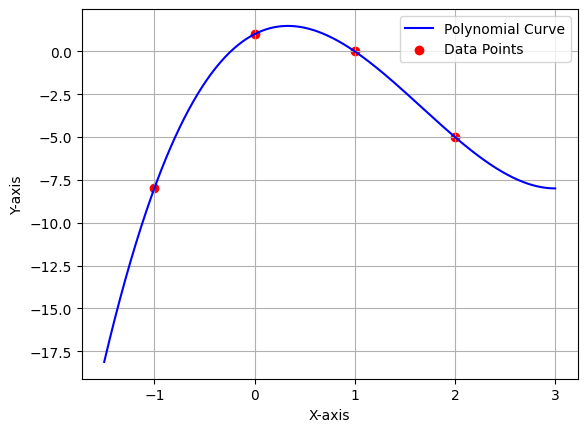

In [37]:
generation = Generation()
generation.run_genetic_algorithm()

now I have tried it with less population size. we can see that it can't find the best solution.

Polynomial equation is: 2 + 2x^1 -7x^2 + 2x^3 
Coefficients are: [2, 2, -7, 2]
MSE in this case is: 1.0


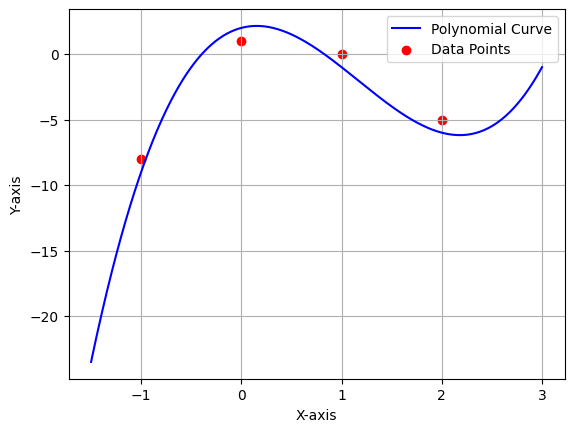

In [36]:
data_table.generation_size = 100

generation = Generation()
generation.run_genetic_algorithm()

by reducing the crossover probability, it takes more time to find the best solution.

Polynomial equation is: 1 + 3x^1 -5x^2 + 1x^3 
Coefficients are: [1, 3, -5, 1]
MSE in this case is: 0.0


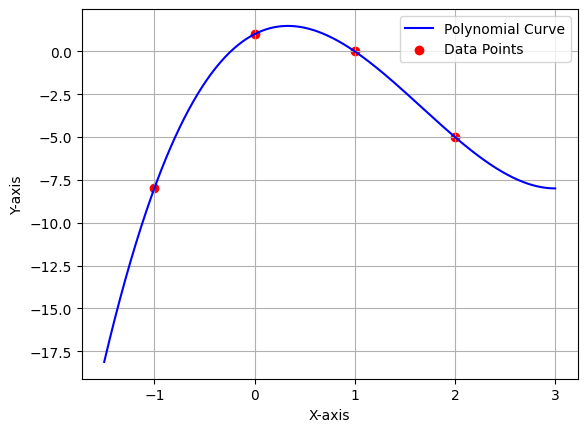

In [39]:
data_table.generation_size = 500
data_table.crossover_probability = 0.2

generation = Generation()
generation.run_genetic_algorithm()

finally we reduced generation size and increased generation numbers and we can see that the algorithm have found the best solution.

Polynomial equation is: 1 + 3x^1 -5x^2 + 1x^3 
Coefficients are: [1, 3, -5, 1]
MSE in this case is: 0.0


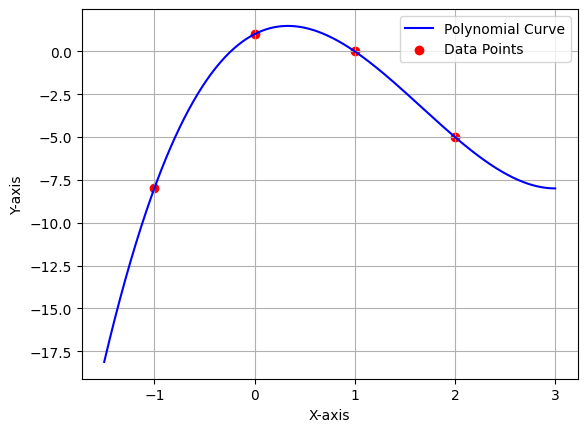

In [40]:
data_table.generation_size = 100
data_table.crossover_probability = 0.6
data_table.generation_number = 2000

generation = Generation()
generation.run_genetic_algorithm()

### Questions

### 1. *What problems will we be facing with if our population is too big or small?* 
 big populationm may help us in terms of finding the optimal solution in less generation numbers because we have more diversity but the problem is it will take more resource(time and memory). 
 small population have less diversity and we may never find an optimal answer.

### 2. *What happens if the population increases after each generations?*
 by growing the population size after each generation, the diversity increases and it may help us but the resource(time and memory) consumption will increase in each step which is a problem. Also we keep the population the same to make our chromosomes converge to optimal answer and by increasing population size, we are not helping our algorithm to converge.

### 3. *What is the effect of crossover and mutation? Is it possible to use only one of them?*
 Crossover makes better chromosomes by combining good chromosomes but mutation changes a chromosome directly and helps us escape a local extremum. For example if we check the best fitness in the population of each generation, we can see that it converges to a number and then a mutation causes it to diverge from that number and suddenly increase.
 We can probably reach the solution by only using one of them but it will be most likely not efficient for example uniform crossover may reach the answer by too many generations and in general only using mutation won't lead us to an optimal answer because it doesn't have the effect of crossover, however in this case for some constants, only using mutation leads to answer.

### 4. *provide some ways which we can make use of to accelerate the algorithm?* 
Choosing the right amount for all constant values can accelerate our algorithm. generation nember and size, mutation and crossover probability have to be choosen carefully.

### 5. *How can we solve the problem of chromosomes not changing after some generations?*
 despite of crossover, mutation can solves ths problem for us. also we can make use of multi-start to increase the probability of finding the actual answer instead of local maximum.

### 6. *What can we do to stop the algorithm if there is no solutions?* 
 We can define a maximum value for the number of the generations to stop the algorithm if it reaches that limit. also we can calculate variances of best chromosomes of some recent generations and compare it with a threshold and terminate if it is less than threshold.

### 7. *By increasing polynomials degree, how does time complextity change?*
 on aggregate, the time needed to find the best coefficients increases but the amount of increase is not the same for all examples. It can be increased exponentialy but in average case, it increases linearly.

### 8. *how does increasing or decreasing point numbers effec on algorithms execution?*
 in average case, time complexity increases linearly.